In [ ]:
# ##The dataset is loaded to your GDrive so need to be mounted
# from google.colab import drive
# import os
# drive.mount('/content/drive')
# os.chdir('/content/drive/My Drive/Colab Notebooks/Satellite Project/')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Dataset, random_split


import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Read Data


In [ ]:
def read_data(data_path, data_type):
    if data_type == 'before':
        data_path = os.path.join(data_path, 'A')
    elif data_type == 'after':
        data_path = os.path.join(data_path, 'B')
    elif data_type == 'label':
        data_path = os.path.join(data_path, 'label')
    else:
        print('data_type is not correct')
        return None

    data = []
    filenames = sorted(os.listdir(data_path))  # Sort filenames
    for filename in filenames:
        img = cv2.imread(os.path.join(data_path, filename))
        data.append(img)
    return data


# display images {before, after, labels}
def display_images(before, after, labels):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(cv2.cvtColor(before, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Before')
    axs[0].axis('off')
    axs[1].imshow(cv2.cvtColor(after, cv2.COLOR_BGR2RGB))
    axs[1].set_title('After')
    axs[1].axis('off')
    axs[2].imshow(labels, cmap='gray')
    axs[2].set_title('Labels')
    axs[2].axis('off')
    plt.show()

In [ ]:
training_path = './trainval/'
before_images = read_data(training_path,'before')
after_images = read_data(training_path, 'after')

In [ ]:
labels = read_data(training_path,'label')

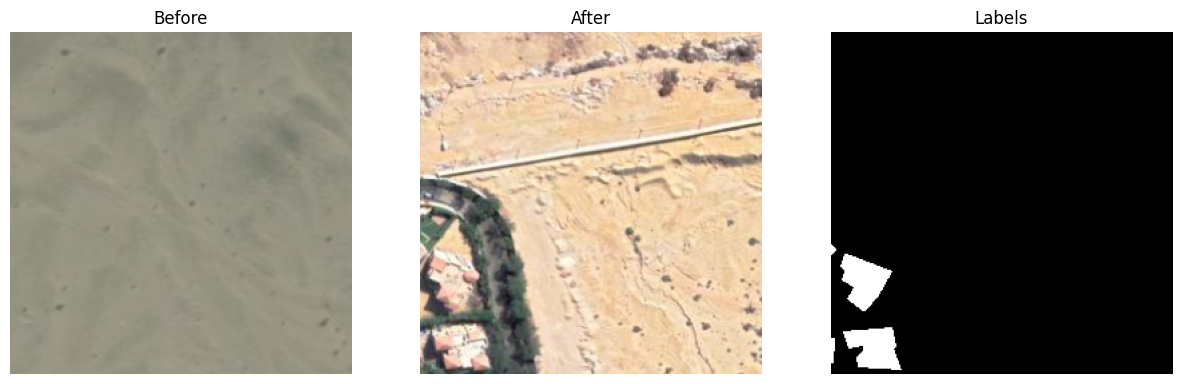

In [ ]:
index = 3
display_images(before_images[index], after_images[index], labels[index])

## Define Dataset


In [ ]:
class ChangeDetectionDataset(Dataset):
    def __init__(self, before_images, after_images, labels, transform=None):
        self.transform = transform
        self.before_images = before_images
        self.after_images = after_images
        self.labels = labels

    def __len__(self):
        return len(self.before_images)  # Return the number of samples

    def __getitem__(self, idx):
        before_image = self.before_images[idx]
        after_image = self.after_images[idx]
        label = self.labels[idx]
        label = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)

        if self.transform:
            before_image = self.transform(before_image)
            after_image = self.transform(after_image)
            label = self.transform(label)

        return before_image, after_image, label

## Define Model


In [ ]:
class ChangeDetectionCNN(nn.Module):
    def __init__(self):
        super(ChangeDetectionCNN, self).__init__()
        # CNN for processing the before image
        self.conv1_before = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2_before = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3_before = nn.Conv2d(32, 64, 3, padding=1)

        # CNN for processing the after image
        self.conv1_after = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2_after = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3_after = nn.Conv2d(32, 64, 3, padding=1)

        # CNN for combining the features
        self.conv_comb = nn.Conv2d(128, 1, 3, padding=1)

    def forward(self, x_before, x_after):
        # Process before image
        x_before = F.relu(self.conv1_before(x_before))
        x_before = F.max_pool2d(x_before, 2)
        x_before = F.relu(self.conv2_before(x_before))
        x_before = F.max_pool2d(x_before, 2)
        x_before = F.relu(self.conv3_before(x_before))
        x_before = F.max_pool2d(x_before, 2)

        # Process after image
        x_after = F.relu(self.conv1_after(x_after))
        x_after = F.max_pool2d(x_after, 2)
        x_after = F.relu(self.conv2_after(x_after))
        x_after = F.max_pool2d(x_after, 2)
        x_after = F.relu(self.conv3_after(x_after))
        x_after = F.max_pool2d(x_after, 2)

        # Concatenate features from before and after images
        x_combined = torch.cat((x_before, x_after), dim=1)

        # Combine features
        x_combined = F.relu(self.conv_comb(x_combined))
        x_combined = F.sigmoid(x_combined)  # Sigmoid activation for binary classification
        return x_combined

## Create Datasets


In [ ]:
data_dir = "./trainval"
batch_size = 20
train_val_ratio = 0.85

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ChangeDetectionCNN().to(device)

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Assuming you have instantiated your dataset like this
dataset = ChangeDetectionDataset(before_images, after_images, labels, transform)

# Define the indices for train and validation sets
train_size = int(train_val_ratio * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Define data loaders for train and validation sets
train_loader = DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle = True)
val_loader = DataLoader(dataset = val_dataset, batch_size=batch_size, shuffle = True)

In [ ]:
print("Train size:", len(train_loader) * batch_size)
print("Validation size:", len(val_loader) * batch_size)

Train size: 4140
Validation size: 740


In [ ]:
after_image, before_image, label = train_dataset[0]
print(label.shape)
print(before_image.shape)

torch.Size([1, 256, 256])
torch.Size([3, 256, 256])


## Create Model


In [ ]:
# Create an instance of the model

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
print(device)

cuda


## Train Model


In [ ]:
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10, save_dir="CNN_models"):
    n_steps = len(train_loader)
    model.to(device)  # Move the model to GPU

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            before_image, after_image, labels = data
            before_image = before_image.to(device)
            after_image = after_image.to(device)
            labels = labels.to(device)

            # Resize labels to match the spatial dimensions of the model's output
            optimizer.zero_grad()
            outputs = model(before_image, after_image)  # Pass both before and after images to the model
            labels_resized = F.interpolate(labels, size=outputs.shape[2:], mode='nearest')
            loss = criterion(outputs, labels_resized)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {(running_loss / n_steps):.4f}')
        running_loss = 0.0

        model_path = os.path.join(save_dir, f'cnn_epoch_{epoch + 1}.pt')
        torch.save(model.state_dict(), model_path)


In [ ]:
# Train the model
train_model(model, train_loader, criterion, optimizer, device, num_epochs=10)

## Validate Model


In [ ]:
def jaccard_index(pred_mask, true_mask):
    intersection = torch.logical_and(pred_mask, true_mask).sum().item()
    union = torch.logical_or(pred_mask, true_mask).sum().item()
    iou = intersection / union if union != 0 else 0.0
    return iou

def evaluate_model(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    total_iou = 0.0
    total_samples = 0

    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            before_images, after_images, labels = data
            before_images = before_images.to(device)
            after_images = after_images.to(device)
            labels = labels.to(device)

            outputs = model(before_images, after_images)
            labels_resized = F.interpolate(labels, size=outputs.shape[2:], mode='nearest')
            pred_masks = torch.round(outputs)

            for pred_mask, true_mask in zip(pred_masks, labels_resized):
                iou = jaccard_index(pred_mask, true_mask)
                total_iou += iou
                total_samples += 1

    mean_iou = total_iou / total_samples
    return mean_iou

In [ ]:
mean_iou = evaluate_model(model, val_loader)
print("Mean Jaccard Index:", mean_iou)

Mean Jaccard Index: 0.0


In [ ]:
def save_output_images(model, test_loader, output_dir, device):
    if not os.path.exists(output_dir):
      os.makedirs(output_dir)
    else:
      # Clear the directory if it already exists
      filelist = [f for f in os.listdir(output_dir)]
      for f in filelist:
          os.remove(os.path.join(output_dir, f))

    with torch.no_grad():
        for idx, data in enumerate(test_loader):
            inputs, _, _ = data  # Unpack inputs, ignoring any additional elements
            inputs = inputs.to(device)  # Move inputs to GPU if available
            outputs = model(inputs)
            pred_masks = torch.argmax(outputs, dim=1)

            for i, pred_mask in enumerate(pred_masks):
                output_filename = os.path.join(output_dir, f"output_{idx * test_loader.batch_size + i}.png")
                pred_mask_img = TF.to_pil_image(pred_mask.byte())  # Convert tensor to PIL image
                pred_mask_img.save(output_filename)

In [ ]:
output_dir = "CNN_output"
save_output_images(model, val_loader, output_dir, device)